In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import re
import warnings
warnings.filterwarnings("ignore")

In [106]:
#1.PPI database
PPP_data = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\PPP_Projects_Total.csv")
#add experience
country_experience = PPP_data.groupby(['countrycode', 'IY']).size().reset_index().sort_values(['countrycode', 'IY'])
country_experience.columns = ['countrycode', 'IY', 'experience']
unique_country = country_experience.countrycode.unique()
years = np.arange(1990, 2020)

In [107]:
for country in unique_country:
    for year in years:
        if year not in country_experience.loc[country_experience.countrycode==country, 'IY'].values:
            country_experience = country_experience.append({'countrycode': country, 'IY': year, 'experience': 0}, ignore_index=True)

country_experience = country_experience.sort_values(by=['countrycode', 'IY']).set_index(np.arange(country_experience.shape[0]))
country_experience['cum_experience'] = country_experience.groupby('countrycode')['experience'].cumsum()
country_experience.drop(columns=['experience'], inplace=True)

country_experience['new_experience'] = country_experience.groupby('countrycode')['cum_experience'].shift(1).fillna(method='bfill')
country_experience.drop(columns=['cum_experience'], inplace=True)

In [112]:
PPP_data = PPP_data.merge(country_experience,
                          left_on=['countrycode', 'IY'],
                          right_on=['countrycode', 'IY'],
                          how='left')

In [113]:
#2.GDP per capita
GDP_per_capita = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP per Capita.csv")
#3.Tax as GDP
tax_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Tax as GDP.csv")
#4.GDP deflator(inflation rate)
GDP_deflator = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP deflator.csv")
#5.life expectnacy
life_expectnacy = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Life expectnacy.csv")
#6.real effective change
real_effective_change = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Real effect change.csv")
#7.electric consumption
electric_consumption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Electric consumption.csv")
#8.domestic credit to private
domestic_credit_to_private = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Domestic credit to private.csv")
#9.Import as GDP
imports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Imports as GDP.csv")
#10.Export as GDP
exports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Exports as GDP.csv")
#11.Control of corruption
control_of_corruption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Control of corruption.csv", encoding='cp1252')
#12.Government of effectiveness
government_effectiveness = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Government effectiveness.csv", encoding='cp1252')
#13.Political stability
political_stability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Political Stability and Absence of Violence.csv", encoding='cp1252')
#14.regulatory quality
regulatory_quality = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Regulatory quality.csv", encoding='cp1252')
#15.Rule of law
rule_of_law = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Rule of law.csv", encoding='cp1252')
#16.voice and accountability
voice_and_accountability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Voice and accountability.csv", encoding='cp1252')

In [114]:
dataset = [GDP_per_capita, 
           tax_as_GDP, 
           GDP_deflator, 
           life_expectnacy, 
           real_effective_change,
           electric_consumption,
           domestic_credit_to_private, 
           imports_as_GDP, 
           exports_as_GDP, 
           control_of_corruption,
           government_effectiveness, 
           political_stability, 
           regulatory_quality, 
           rule_of_law, 
           voice_and_accountability]

dataset_name = ['GDP_per_capita', 
                'tax_as_GDP', 
                'GDP_deflator', 
                'life_expectnacy', 
                'real_effective_change',
                'electric_consumption', 
                'domestic_credit_to_private', 
                'imports_as_GDP', 
                'exports_as_GDP', 
                'control_of_corruption',
                'government_effectiveness',
                'political_stability', 
                'regulatory_quality', 
                'rule_of_law', 
                'voice_and_accountability']

In [115]:
def process_data(original_data):
    new_data = original_data.copy()
    new_data.replace('..', np.nan, inplace=True)
    new_data.drop(columns=['Series Name', 'Series Code', 'Country Name'], inplace=True)
    new_data.set_index('Country Code', inplace=True)
    new_data.dropna(how='all', inplace=True)
    new_data.columns = [name.split(' ')[0] for name in list(new_data.columns)]
    new_data = new_data.fillna(axis=1, method='bfill')
    new_data = new_data.fillna(axis=1, method='ffill')
    return new_data

for i in np.arange(len(dataset)):
    dataset[i] = process_data(dataset[i])

In [116]:
def meltdata(raw_data, column_name):
    new_data = pd.melt(raw_data.reset_index(), 
                       id_vars=['Country Code'], 
                       var_name=['Year'],
                       value_vars=raw_data.columns,
                       value_name=column_name)
    new_data.Year = new_data.Year.astype('int64', copy=False)
    return new_data

for i,name in zip(np.arange(len(dataset)), dataset_name):
    dataset[i] = meltdata(dataset[i], name).copy()
    dataset[i].rename(columns={'Country Code': 'countrycode', 
                               'Year': 'IY'}, 
                      inplace=True)

for data in dataset:
    PPP_data= PPP_data.merge(data, 
                             left_on=['countrycode', 'IY'], 
                             right_on=['countrycode', 'IY'], 
                             how='left')

In [117]:
data = PPP_data.copy()

In [118]:
float_value = ['GDP_per_capita', 
               'tax_as_GDP', 
               'GDP_deflator', 
               'life_expectnacy', 
               'real_effective_change',
               'electric_consumption', 
               'domestic_credit_to_private', 
               'imports_as_GDP', 
               'exports_as_GDP', 
               'control_of_corruption',
               'government_effectiveness', 
               'political_stability', 
               'regulatory_quality', 
               'rule_of_law', 
               'voice_and_accountability']
nominal_value = ['IDA', 
                 'Region',
                 'type', 
                 'stype', 
                 'sector',
                 'Segment', 
                 'UP', 
                 'PublicDisclosure', 
                 'shareborder', 
                 'PRS', 
                 'Renewables', 
                 'MLS', 
                 'GGC',
                 'lendingtype']
ordinal_value = ['incomelevel']
float_value_2 = ['period', 
                 'realphysicalassets', 
                 'investment_real', 
                 'GDP', 
                 'population', 
                 'CPI2019',
                 'bordercountries', 
                 'private', 
                 'physical', 
                 'period',
                 'investment', 
                 'pcapacity']
data.drop(columns=['bid_crit', 
                   'country', 
                   'regionname',
                   'adminregion',
                   'region',
                   'Description',
                   'adminregionname',
                   'incomelevelname',
                   'income',
                   'lendingtypename',
                   'BS',
                   'PCO',
                   'TIGS'], inplace=True)

data.replace('..', np.nan, inplace=True)
data.replace({'status_n': {'Cancelled': 'fail', 
                           'Distressed': 'fail', 
                           'Active': 'success',
                           'Concluded': 'success'}}, inplace=True)

for float_column in float_value + float_value_2:
    data[float_column] = data[float_column].astype(float)

In [119]:
#split the data
X = data[data.columns[data.columns!='status_n']]
y = data['status_n']
#income value is ordinal value
mapper = {'LIC': 1, 
          'HIC': 4, 
          'LMC': 2, 
          'UMC': 3, 
          np.nan: 1}
X.loc[:, 'incomelevel'] = X.incomelevel.map(mapper)
#convert the FCY to datetime
X.loc[:, 'FCY'] = pd.DatetimeIndex(X.FCY).year
predicted_status = {'success': 0, 
                    'fail': 1}
y = y.map(predicted_status)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y, shuffle=True)

In [120]:
#get the corrlation that larger than a threshold, for numeric data.
def find_correlation(data, threshold):
    correlated_column = defaultdict(list)
    correlation_matrix = data.corr()
    for i, row in correlation_matrix.iterrows():
        for column in correlation_matrix.columns:
            if (abs(row[column]) > threshold) & (abs(row[column]) != 1.0):
                correlated_column[i].append(column)
    return correlated_column

In [121]:
X_cor_train = X_train.join(y_train)

In [122]:
X_cor_train.corr()['status_n'].sort_values()

IY                           -0.221367
FCY                          -0.221228
new_experience               -0.116239
electric_consumption         -0.104111
GDP                          -0.099028
GDP_per_capita               -0.097827
life_expectnacy              -0.096763
domestic_credit_to_private   -0.094142
population                   -0.066675
government_effectiveness     -0.054775
private                      -0.043239
tax_as_GDP                   -0.024212
rule_of_law                  -0.019434
control_of_corruption        -0.015206
GDP_deflator                 -0.006204
period                       -0.005746
pcapacity                    -0.002988
bordercountries               0.000556
exports_as_GDP                0.009201
incomelevel                   0.010295
political_stability           0.012121
imports_as_GDP                0.012302
physical                      0.013476
real_effective_change         0.015014
investment                    0.016833
regulatory_quality       

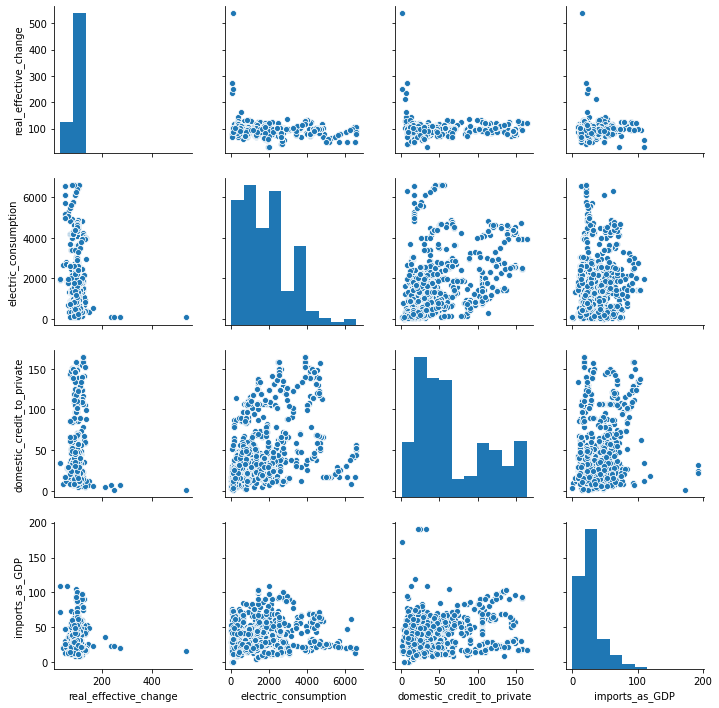

In [572]:
sns.pairplot(X_train.iloc[:, 34:38])

In [123]:
correlated_column = find_correlation(X_train, 0.9)

In [124]:
for k, v in correlated_column.items():
    print(f"{k}-{v}")

IY-['FCY', 'CPI2019']
FCY-['IY', 'CPI2019']
physical-['realphysicalassets']
investment-['investment_real']
GDP-['new_experience']
CPI2019-['IY', 'FCY']
investment_real-['investment']
realphysicalassets-['physical']
new_experience-['GDP']


In [125]:
column_to_be_dropped = ['FCY',
                        'CPI2019',
                        'physical',
                        'investment',
                        'exports_as_GDP']
X_train.drop(columns=column_to_be_dropped, inplace=True)
X_test.drop(columns=column_to_be_dropped, inplace=True)

In [126]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5322 entries, 851 to 4383
Data columns (total 41 columns):
IY                            5322 non-null int64
Region                        5322 non-null object
IDA                           5322 non-null object
type                          5322 non-null object
stype                         5322 non-null object
sector                        5322 non-null object
ssector                       5322 non-null object
Segment                       5322 non-null object
period                        3858 non-null float64
GGC                           4272 non-null object
private                       5121 non-null float64
pcapacity                     4566 non-null float64
PRS                           5318 non-null object
UP                            5322 non-null object
PublicDisclosure              5322 non-null object
bordercountries               5322 non-null float64
shareborder                   5322 non-null object
countrycode          

In [19]:
# one factor
def fill_missing_float_1(train_data, test_data, group_list, column):
    train = train_data.copy()
    test = test_data.copy()
    grouped_period = train.groupby(group_list)[column].mean().to_frame()
    for i, rows in grouped_period.iterrows():
        train_filled = train.loc[train[group_list[0]] == i[0], column]
        test_filled = test.loc[test[group_list[0]] == i[0], column]
        train.loc[train[group_list[0]] == i[0], column] = train_filled.fillna(rows[column])
        test.loc[test[group_list[0]] == i[0], column] = test_filled.fillna(rows[column])
    train.loc[:, column] = train[column].fillna(train[column].mean())
    test.loc[:, column] = test[column].fillna(train[column].mean())
    return train, test  

# two factors.
def fill_missing_float_2(train_data, test_data, group_list, column):
    train = train_data.copy()
    test = test_data.copy()
    grouped_period = train.groupby(group_list)[column].mean().to_frame()
    for i, rows in grouped_period.iterrows():
        train_filled = train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]), column]
        test_filled = test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]), column]
        train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]), column] = train_filled.fillna(rows[column])
        test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]), column] = test_filled.fillna(rows[column])
    train.loc[:, column] = train[column].fillna(train[column].mean())
    test.loc[:, column] = test[column].fillna(train[column].mean())
    return train, test        

# two factors.
def fill_missing_float_3(train_data, test_data, group_list, column):
    train = train_data.copy()
    test = test_data.copy()
    grouped_period = train.groupby(group_list)[column].mean().to_frame()
    for i, rows in grouped_period.iterrows():
        train_filled = train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]) & (train[group_list[2]] == i[2]), column]
        test_filled = test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]) & (train[group_list[2]] == i[2]), column]
        train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]) & (train[group_list[2]] == i[2]), column] = train_filled.fillna(rows[column])
        test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]) & (train[group_list[2]] == i[2]), column] = test_filled.fillna(rows[column])
    train.loc[:, column] = train[column].fillna(train[column].mean())
    test.loc[:, column] = test[column].fillna(train[column].mean())
    return train, test   

#first fillna for training dataset based on country, if some countries are non, then fill with the mode in current column, the same for test dataset.
def fillna_for_nominal_1(train_dataset, test_dataset, group_list, column):
    train = train_dataset.copy()
    test = test_dataset.copy()
    mode_in_train = train.groupby(group_list)[column].agg(pd.Series.mode).to_frame()
    for index, row in mode_in_train.iterrows():
        if type(row[column]) == np.ndarray:
            mode_in_train.loc[index, column] = train[column].mode()[0]
    for i, rows in mode_in_train.iterrows():
            train_filled = train.loc[(train[group_list[0]] == i[0]), column]
            test_filled = test.loc[(test[group_list[0]] == i[0]), column]
            train.loc[(train[group_list[0]] == i[0]), column] = train_filled.fillna(rows[column])
            test.loc[(test[group_list[0]] == i[0]), column] = test_filled.fillna(rows[column])
    train.loc[:, column] = train[column].fillna(train[column].mode()[0])
    test.loc[:, column] = test[column].fillna(train[column].mode()[0])       
    return train, test

#first fillna for training dataset based on country, if some countries are non, then fill with the mode in current column, the same for test dataset.
def fillna_for_nominal_2(train_dataset, test_dataset, group_list, column):
    train = train_dataset.copy()
    test = test_dataset.copy()
    mode_in_train = train.groupby(group_list)[column].agg(pd.Series.mode).to_frame()
    for index, row in mode_in_train.iterrows():
        if type(row[column]) == np.ndarray:
            mode_in_train.loc[index, column] = train[column].mode()[0]
    for i, rows in mode_in_train.iterrows():
            train_filled = train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]), column]
            test_filled = test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]), column]
            train.loc[(train[group_list[0]] == i[0]) & (train[group_list[1]] == i[1]), column] = train_filled.fillna(rows[column])
            test.loc[(test[group_list[0]] == i[0]) & (test[group_list[1]] == i[1]), column] = test_filled.fillna(rows[column])
    train.loc[:, column] = train[column].fillna(train[column].mode()[0])
    test.loc[:, column] = test[column].fillna(train[column].mode()[0])       
    return train, test

In [127]:
X_test.shape

(1774, 41)

In [128]:
#categorical value.
X_train, X_test = fillna_for_nominal_2(X_train, X_test, ['countrycode', 'ssector'], 'GGC')
X_train, X_test = fillna_for_nominal_2(X_train, X_test, ['countrycode', 'ssector'], 'PRS')
X_train, X_test = fillna_for_nominal_2(X_train, X_test, ['countrycode', 'ssector'], 'lendingtype')
#numeric value from original database.
X_train, X_test = fill_missing_float_2(X_train, X_test, ['stype', 'ssector'], 'period')
X_train, X_test = fill_missing_float_3(X_train, X_test, ['stype', 'ssector', 'countrycode'], 'private')
X_train, X_test = fill_missing_float_2(X_train, X_test, ['countrycode', 'ssector'], 'pcapacity')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'population')
X_train, X_test = fill_missing_float_2(X_train, X_test, ['stype', 'ssector'], 'investment_real')
X_train, X_test = fill_missing_float_3(X_train, X_test, ['stype', 'ssector', 'countrycode'], 'realphysicalassets')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'GDP')
#numeric value from other databases.
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'GDP_per_capita')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'control_of_corruption')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'tax_as_GDP')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'GDP_deflator')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'real_effective_change')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'imports_as_GDP')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'government_effectiveness')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'political_stability')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'regulatory_quality')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'rule_of_law')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'voice_and_accountability')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'life_expectnacy')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'electric_consumption')
X_train, X_test = fill_missing_float_1(X_train, X_test, ['Region'], 'domestic_credit_to_private')

In [129]:
X_train.drop(columns=['countrycode'], inplace=True)
X_test.drop(columns=['countrycode'], inplace=True)

In [130]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [131]:
#to make sure the train and test dataset have the same shape
train_objs_num = len(X_train)
combine_dataset = pd.concat(objs=[X_train, X_test], axis=0)
dataset_preprocessed = pd.get_dummies(combine_dataset, columns=X_train.columns[X_train.dtypes == object], drop_first=True)
X_train = dataset_preprocessed[:train_objs_num]
X_test = dataset_preprocessed[train_objs_num:]

In [132]:
#scaling data
scaler = RobustScaler()
numeric_column = X_train.columns[X_train.dtypes == 'float64']
X_train[numeric_column] = scaler.fit_transform(X_train[numeric_column])
X_test[numeric_column] = scaler.transform(X_test[numeric_column])

In [169]:
X_bal, y_bal = ADASYN(sampling_strategy='minority',random_state=0).fit_resample(
    X_train,
    y_train)

In [170]:
X_bal = pd.DataFrame(X_bal, columns=X_train.columns)
y_bal = pd.DataFrame(y_bal, columns=['status_n'])
balanced = X_bal.join(y_bal)

bal_corr = balanced.corr()

<BarContainer object of 103 artists>

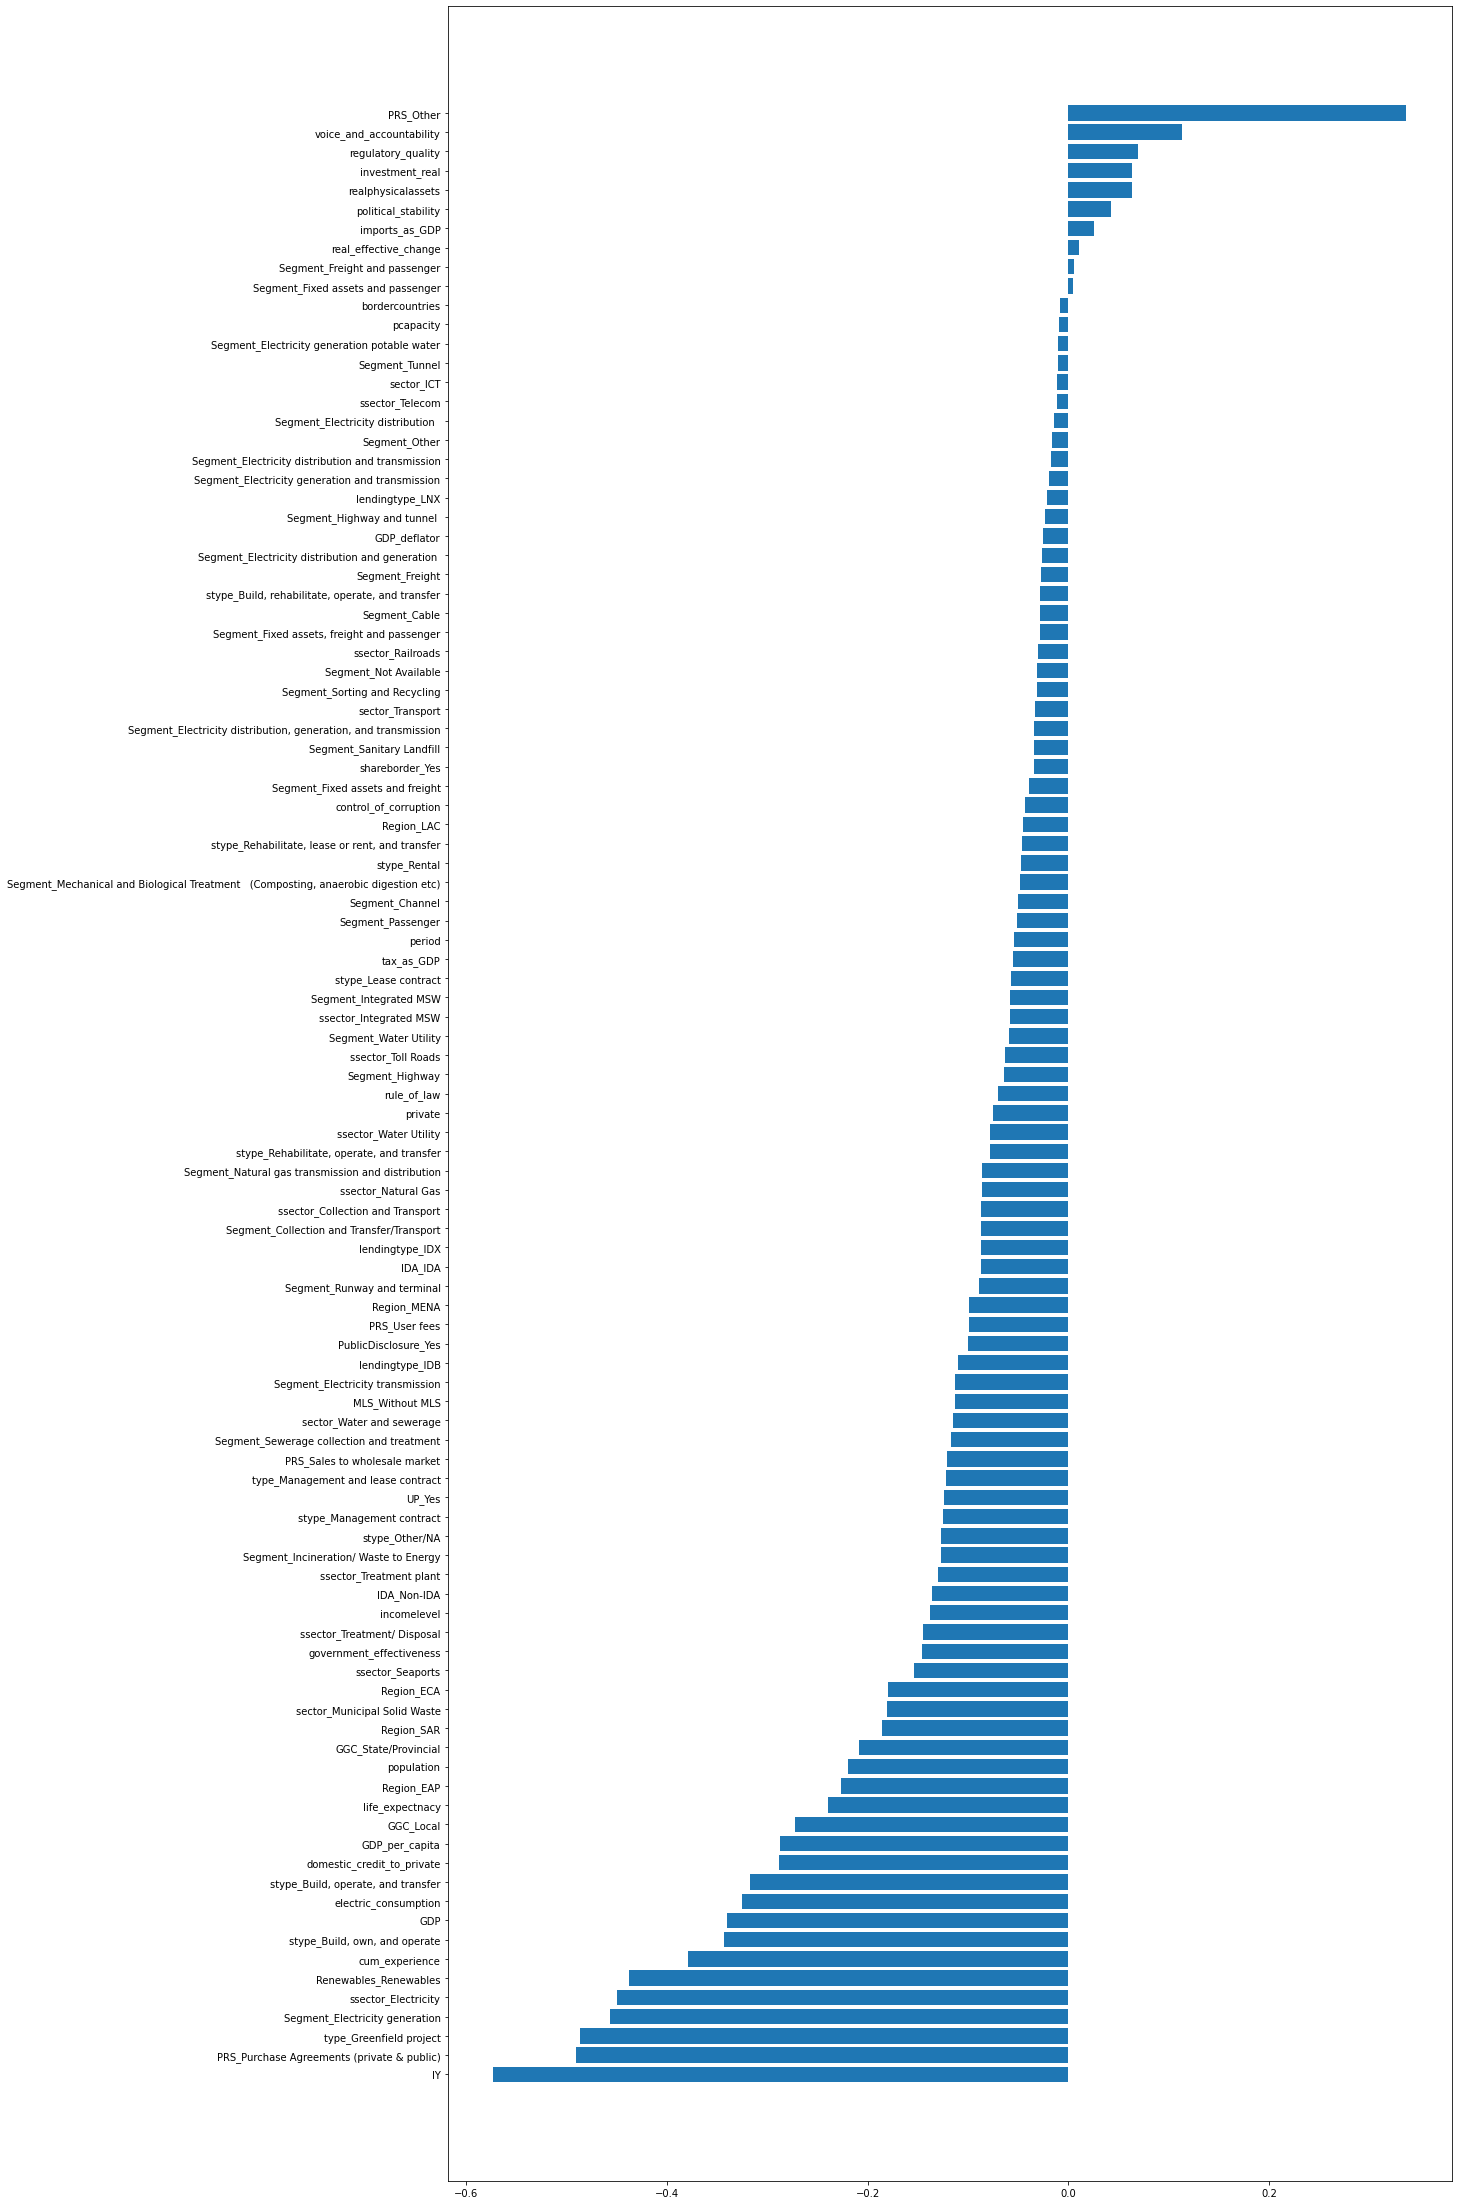

In [405]:
plt.figure(figsize=(18,40))
sorted_correlation =  bal_corr.sort_values(by='status_n', ascending=True)
plt.barh(sorted_correlation.status_n[:-2].index, sorted_correlation.status_n[:-2])

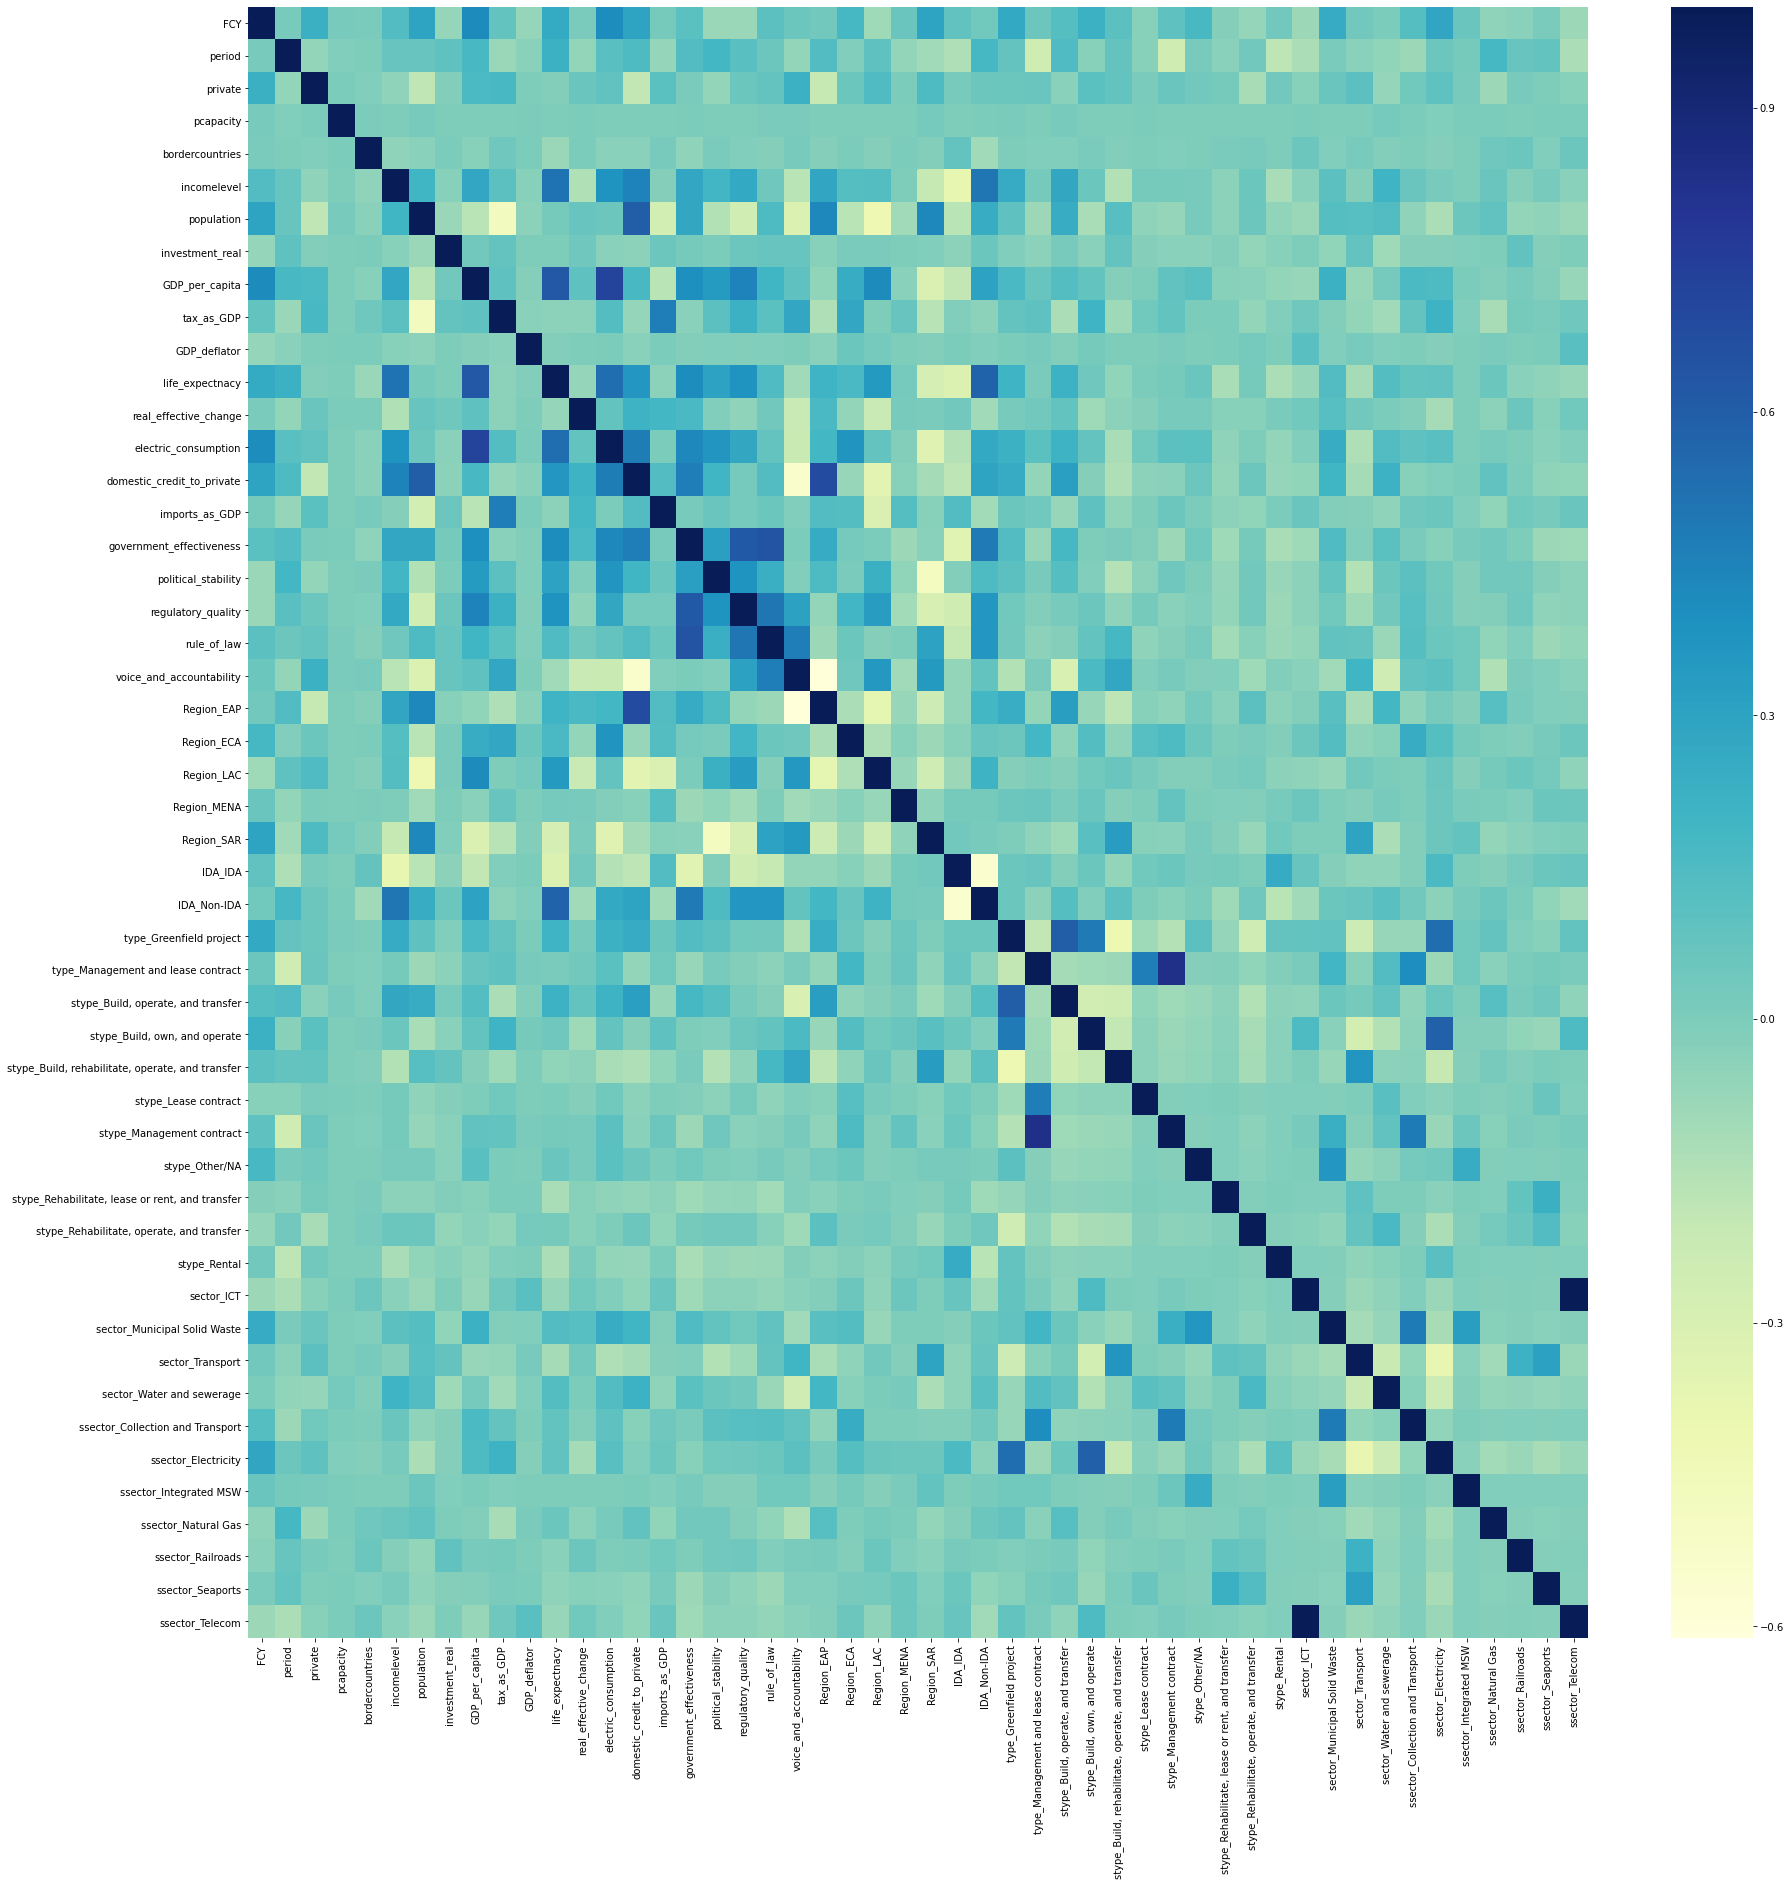

In [86]:
plt.figure(figsize=(30,30))
sns.heatmap(bal_corr.iloc[:50, 0:50], annot_kws={'size':20}, cmap="YlGnBu")

In [172]:
no_outliers = pd.DataFrame(balanced.copy())
cols = bal_corr.status_n.index[:-1]
for col in cols:
    correlation = bal_corr.loc['status_n', col]
    if np.abs(correlation) > 0.1:
        nonfrauds = no_outliers.loc[no_outliers.status_n==0, col]
        frauds = no_outliers.loc[no_outliers.status_n==1, col]
        
        all_values = no_outliers.loc[:,col]
        q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
        iqr = q75 - q25
        cutoff = iqr * 7
        lower, upper = q25 - cutoff, q75 + cutoff
        if correlation > 0: 
            no_outliers.drop(index=nonfrauds[nonfrauds>upper].index,inplace=True)
            no_outliers.drop(index=frauds[frauds<lower].index,inplace=True)
        elif correlation < 0: 
            no_outliers.drop(index=nonfrauds[nonfrauds<lower].index,inplace=True)
            no_outliers.drop(index=frauds[frauds>upper].index,inplace=True)

In [173]:
y_bal.shape

(10213, 1)

In [174]:
feat_sel =pd.DataFrame(no_outliers.copy())

In [175]:
feat_sel.shape

(8779, 105)

In [176]:
new_corr = feat_sel.corr()
for col in new_corr.status_n.index[:-1]:
    if np.abs(new_corr.loc['status_n', col]) < 0.1:
        feat_sel.drop(columns=col, inplace=True)

In [177]:
X_new_train = feat_sel.drop('status_n', 1)

In [178]:
X_new_train = feat_sel.drop('status_n', 1)
y_new_train = feat_sel.status_n

cols = X_new_train.columns
X_new_test = X_test[cols]

#X_train, y_train = RandomUnderSampler(sampling_strategy={1:5000,0:5000}).fit_resample(X_train,y_train)
X_new_train, y_new_train = ADASYN(sampling_strategy='minority',random_state=0).fit_resample(
    X_new_train,
    y_new_train)

In [179]:
X_new_train.shape

(10285, 46)

In [180]:
X_new_test.shape

(1774, 46)

In [181]:
y_new_train.sum()/len(y_new_train)

0.5026737967914439

In [38]:
def plot_roc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return (fpr, tpr, thresholds)

def plot_recall_precision(y_true, y_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
    plt.title('Recall-Precision')
    plt.plot(recall, precision, 'k')
    no_skill = y_true.sum()/len(y_true)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    plt.legend(loc = 'lower right')
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    return (precision, recall, thresholds)

def plot_cm(labels, predictions, p=0.1):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [182]:
#clf and upsample
clf = RandomForestClassifier(random_state=1)
param_grid = {'n_estimators': [int(x) for x in np.linspace(700, 2000, 30)],
              'max_features': ['auto', 'sqrt'], 
              'max_depth': [int(x) for x in np.linspace(10, 80, 30)],
              'min_samples_split': [int(x) for x in np.linspace(2, 30, 20)],
              'min_samples_leaf': [int(x) for x in np.linspace(2, 30, 20)],
              'bootstrap': [True, False]}
clf_random_grid = RandomizedSearchCV(clf,
                                     param_grid, 
                                     refit=True, 
                                     verbose=-1, 
                                     cv=3,
                                     n_jobs=-1,
                                     random_state=123)
clf_random_grid.fit(X_new_train, y_new_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 12, 14, 17, 19, 22,
                                                      24, 26, 29, 31, 34, 36,
                                                      38, 41, 43, 46, 48, 51,
                                                      53, 55, 58, 60, 63, 65,
                                                      67, 70, 72, 75, 77, 80],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 3, 4, 6, 7, 9,
                                                             10, 12, 13, 15, 16,
                                                             18, 19, 21, 22, 24,
                                                             25, 27, 28, 30],
                                        'mi

In [183]:
clf_random_grid.best_params_

{'n_estimators': 1103,
 'min_samples_split': 4,
 'min_samples_leaf': 6,
 'max_features': 'sqrt',
 'max_depth': 36,
 'bootstrap': True}

In [795]:
param_grid = {'n_estimators': [1370, 1372, 710],
              'max_features': ['sqrt'], 
              'max_depth': [55, 56, 57],
              'min_samples_split': [21, 22, 23],
              'min_samples_leaf': [2],
              'bootstrap': [False]}
clf_grid = GridSearchCV(clf, 
                        param_grid, 
                        refit=True, 
                        verbose=-1, 
                        cv=3,
                        n_jobs=-1)
clf_grid.fit(X_new_train, y_new_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  3.2min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [55, 56, 57],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2],
                         'min_samples_split': [21, 22, 23],
                         'n_estimators': [690, 700, 710]},
             verbose=-1)

In [799]:
clf_grid.best_params_

{'bootstrap': False,
 'max_depth': 55,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 22,
 'n_estimators': 690}

In [184]:
#clf and upsample
pred_clf_upsample = cross_val_predict(clf_random_grid.best_estimator_,
                                      X_new_test,
                                      y_test,                                      
                                      method='predict_proba',
                                      cv=5)

(array([0.00000000e+00, 5.86510264e-04, 1.75953079e-03, 1.75953079e-03,
        4.10557185e-03, 4.10557185e-03, 5.27859238e-03, 5.27859238e-03,
        5.86510264e-03, 5.86510264e-03, 7.62463343e-03, 7.62463343e-03,
        8.79765396e-03, 8.79765396e-03, 9.97067449e-03, 9.97067449e-03,
        1.11436950e-02, 1.11436950e-02, 1.17302053e-02, 1.17302053e-02,
        1.23167155e-02, 1.23167155e-02, 1.34897361e-02, 1.34897361e-02,
        1.70087977e-02, 1.70087977e-02, 1.99413490e-02, 2.11143695e-02,
        3.04985337e-02, 3.04985337e-02, 3.10850440e-02, 3.10850440e-02,
        3.16715543e-02, 3.16715543e-02, 3.28445748e-02, 3.28445748e-02,
        3.51906158e-02, 3.51906158e-02, 3.57771261e-02, 3.69501466e-02,
        3.81231672e-02, 3.81231672e-02, 4.04692082e-02, 4.04692082e-02,
        4.16422287e-02, 4.16422287e-02, 4.22287390e-02, 4.22287390e-02,
        4.63343109e-02, 4.63343109e-02, 5.63049853e-02, 5.63049853e-02,
        5.74780059e-02, 6.45161290e-02, 6.56891496e-02, 6.627565

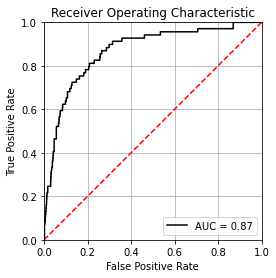

In [185]:
plot_roc(y_test, pred_clf_upsample[:,1])

No handles with labels found to put in legend.


(array([0.04445876, 0.04322581, 0.04325371, ..., 0.        , 0.        ,
        1.        ]),
 array([1.        , 0.97101449, 0.97101449, ..., 0.        , 0.        ,
        0.        ]),
 array([0.00073224, 0.00073794, 0.0007385 , ..., 0.41873379, 0.43585047,
        0.44284014]))

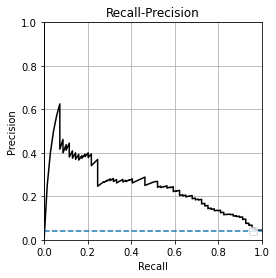

In [186]:
plot_recall_precision(y_test, pred_clf_upsample[:,1])

In [187]:
confusion_matrix(y_test, pred_clf_upsample[:, 1] > 0.1)

array([[1526,  179],
       [  24,   45]], dtype=int64)

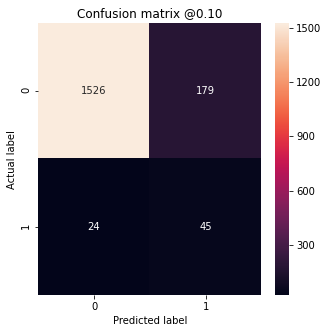

In [188]:
plot_cm(y_test, pred_clf_upsample[:, 1])

In [152]:
#feature importance
fi = pd.DataFrame({'feature': list(X_new_train.columns),
                   'importance': clf_random_grid.best_estimator_.feature_importances_}).\
                    sort_values('importance', ascending = False)

In [153]:
fi.head(40)

,feature,importance
0,IY,0.137008
38,GGC_Local,0.071274
1,GDP,0.065529
41,PRS_Purchase Agreements (private & public),0.064511
20,"stype_Build, own, and operate",0.055764
2,population,0.053143
3,new_experience,0.049115
47,Renewables_Renewables,0.040308
39,GGC_State/Provincial,0.035993
26,ssector_Electricity,0.033509


In [189]:
X_train_lgb = X_new_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test_lgb = X_new_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_train_lgb = y_new_train.copy()
y_test_lgb = y_test.copy()
clf_lgb = lgb.LGBMClassifier(random_state=1)

param_grid = {'learning_rate': [x for x in np.linspace(0.005, 0.01, 3)],
              'n_estimators': [int(x) for x in np.linspace(700, 2000, 30)],
              'num_leaves': [int(x) for x in np.linspace(10, 40, 30)],
              'boosting_type' : ['gbdt'],
              'objective' : ['binary'],
              'random_state' : [501], 
              'colsample_bytree' : [x for x in np.linspace(0.1, 1.0, 30)],
              'subsample' : [x for x in np.linspace(0.1, 1.0, 30)]}
lgb_random_grid = RandomizedSearchCV(clf_lgb,                                     
                                     param_grid, 
                                     refit=True, 
                                     verbose=-1, 
                                     cv=2,
                                     n_jobs=-1,
                                     random_state=123)
lgb_random_grid.fit(X_train_lgb, y_train_lgb)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   20.8s finished


RandomizedSearchCV(cv=2, estimator=LGBMClassifier(random_state=1), n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.1,
                                                             0.1310344827586207,
                                                             0.16206896551724137,
                                                             0.19310344827586207,
                                                             0.22413793103448276,
                                                             0.25517241379310346,
                                                             0.28620689655172415,
                                                             0.3172413793103448,
                                                             0.34827586206896555,
                                                             0.3793103448275862,
                                                      

In [190]:
lgb_random_grid.best_params_

{'subsample': 0.3793103448275862,
 'random_state': 501,
 'objective': 'binary',
 'num_leaves': 32,
 'n_estimators': 1058,
 'learning_rate': 0.0075,
 'colsample_bytree': 0.19310344827586207,
 'boosting_type': 'gbdt'}

In [191]:
pred_lgb_upsample = cross_val_predict(lgb_random_grid.best_estimator_,
                                      X_test_lgb,
                                      y_test_lgb,
                                      method='predict_proba',
                                      cv=5)

(array([0.00000000e+00, 5.86510264e-04, 5.86510264e-04, 1.17302053e-03,
        1.17302053e-03, 1.75953079e-03, 1.75953079e-03, 5.27859238e-03,
        5.27859238e-03, 6.45161290e-03, 6.45161290e-03, 7.62463343e-03,
        7.62463343e-03, 9.97067449e-03, 9.97067449e-03, 1.11436950e-02,
        1.23167155e-02, 1.40762463e-02, 1.52492669e-02, 2.28739003e-02,
        2.28739003e-02, 2.46334311e-02, 2.46334311e-02, 2.52199413e-02,
        2.52199413e-02, 2.63929619e-02, 2.63929619e-02, 2.69794721e-02,
        2.69794721e-02, 2.81524927e-02, 2.81524927e-02, 2.93255132e-02,
        2.93255132e-02, 3.10850440e-02, 3.10850440e-02, 3.46041056e-02,
        3.81231672e-02, 4.10557185e-02, 4.10557185e-02, 4.28152493e-02,
        4.28152493e-02, 4.34017595e-02, 4.45747801e-02, 4.45747801e-02,
        5.27859238e-02, 5.27859238e-02, 5.45454545e-02, 5.57184751e-02,
        5.63049853e-02, 5.63049853e-02, 5.98240469e-02, 5.98240469e-02,
        6.39296188e-02, 6.56891496e-02, 6.56891496e-02, 6.862170

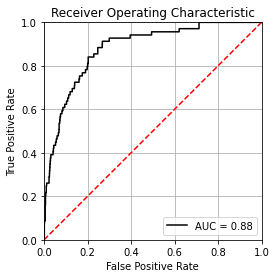

In [192]:
plot_roc(y_test, pred_lgb_upsample[:,1])

No handles with labels found to put in legend.


(array([0.05373832, 0.05226209, 0.05246672, ..., 0.5       , 0.        ,
        1.        ]),
 array([1.        , 0.97101449, 0.97101449, ..., 0.01449275, 0.        ,
        0.        ]),
 array([1.00514232e-04, 1.00747964e-04, 1.01052230e-04, ...,
        9.04080358e-01, 9.18419828e-01, 9.60901743e-01]))

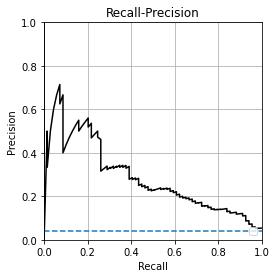

In [193]:
plot_recall_precision(y_test_lgb, pred_lgb_upsample[:,1])

In [197]:
confusion_matrix(y_test, pred_lgb_upsample[:, 1] > 0.1)

array([[1647,   58],
       [  42,   27]], dtype=int64)

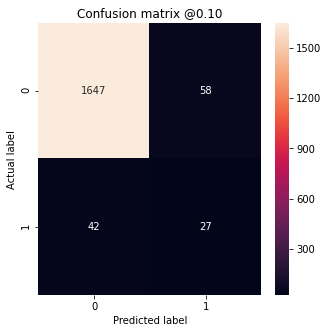

In [195]:
plot_cm(y_test_lgb, pred_lgb_upsample[:, 1])